# Mechanics of Protocol for Opioid Weaning

In [61]:
# Imports
from IPython import display
import numpy
import pandas
from scipy import special
import sys
sys.path.append('/Users/jim/repos/poincare/axiom')
from axiom.vis.plotting.ggplot2 import image, gg2

_A mathematical explanation_

## Overview

Presentation:
- Useful terms
- Choice of model (curve)
- Parameterisation of model
- Formalisation of algorithm

Additional:
- Analysis of retrospective data (preliminary)
- Simulation of protocol (preliminary)

## Useful terms

- _intake_ - amount of opioid consumed by patient (OMeq)
- _proscribed_ - maximum amount of opioid allowed for patient intake (OMeq)
- _model_ - functional form of the proscribed in terms of intake
- _protocol_ - algorithm that uses the model to calculate a proscribed maximum intake based on recent observations

## Choice of model

Objectives of model behavior:
* smoothness, continuity
* control of maximum value
* control of maximum gradient

The above criteria are well-satisfied by the family of sigmoids (s-curves). Some common s-curve functional-forms are:
* logistic
* Error function (erfc)
* Hyperbolic tangent
* Inverse tangent (arctan)

### Sigmoid Curves

Of the many functional forms, the logistic function strikes a optimal* balance between smoothness and steepness, which can be seen in the comparison plot below:

In [54]:
def logistic(x):
    return 1/(1 + numpy.exp(-x))

def erf(x):
    return (special.erf(.3*x) + 1)/2

def arctan(x):
    return (numpy.arctan(x) + numpy.pi/2)/numpy.pi

def hypertan(x):
    return (numpy.tanh(.8*x) + 1)/2

In [55]:
xs = numpy.arange(-10, 10, 0.1)
df = pandas.DataFrame({'X':xs,
                       'Logistic':logistic(xs),
                       'Erf':erf(xs),
                       'Arctan': arctan(xs),
                       'Hypertan': hypertan(xs)})
tmp = df.set_index('X').stack().to_frame('Value').reset_index().rename(columns={'level_1':'Function'})
plot = gg2.ggplot(tmp) + gg2.aes_string(x='X', y='Value', color='Function') + gg2.geom_line() + gg2.ggtitle('Comparison of Sigmoid functional forms')

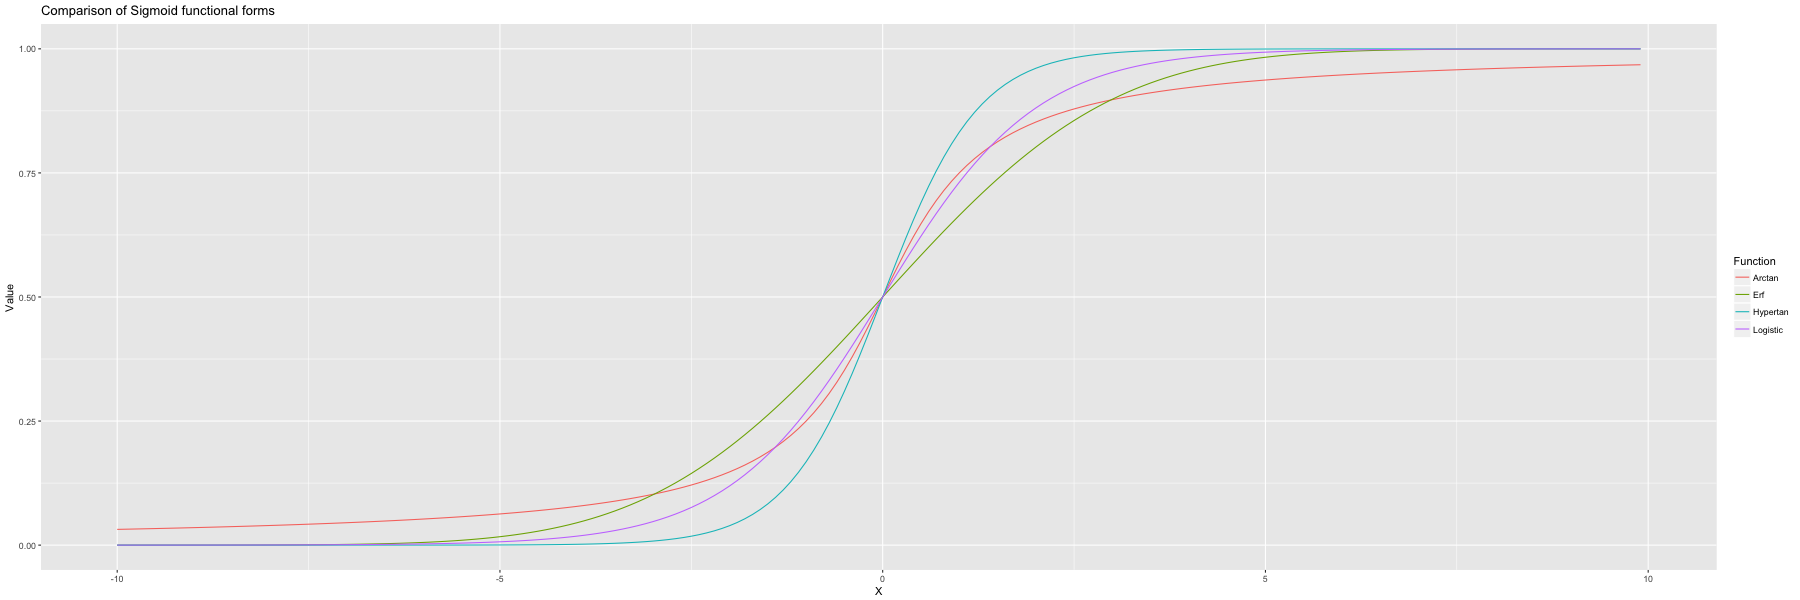

In [90]:
image(plot, width=1800, height=600)

*optimal in this sense refers to the dominance of exponential behavior over linear behavior as a function of distance-from-center

### Logistic function

The logistic function is an optimal choice for a few reasons:
- ease of understanding and manipulation
- numerical cost of calculation is lowest
- technically "smoothest" in certain maths contexts 

$$\Large{f(x) = \frac{1}{1 + e^{-x}}}$$

### Interesting Aside - Neural Network "Neuron"s

Sigmoid curves are frequently used to represent the response of a neuron to a given stimulus, its "transfer-function", in machine-learning techniques known as a neural-networks. These techniques attempt to mimic the behavior of organic computation numerically, through a variety of combinatorial algorithms.

## Choosing Model Parameters

The model $\mathcal{M}$ below relates the _intake_ $s$ to the _proscribed_ $p$ by means of a logistic function with parameters:
- $\nu$ maximum allowable proscribed value
- $\eta$ maximum rate of change of proscribed with respect to intake, "max weaning"
- $s_o$ "middle" level of intake, point of maximum decrease of prosribed

$$\Large{\mathcal{M}(\nu, \eta, s_o)} =  m_{\nu\eta s_o} : s\rightarrow p$$

$$\Large{m_{\nu\eta s_o}(s) = \frac{\nu}{1 + e^{4\eta\left(s-s_o\right)}}}$$

## Formalisation of protocol

The protocol adds 1 dimension of complexity to the model, time. In the following, $t$ will refer to the "present" and $t-n$ refers to "n days ago".

The terms from the model carry over, but are now time-ordered observations. For instance, the intake at $t$ is $s_t$ and the proscribed at $t$ is $p_t$, etc.

### Aims of protocol

The protocol aims to guide $p_t$ by using a recent intake "trend" (to be defined shortly). The protocol recognizes and responds to 3 types of behavior of the intake trend:
- _decreasing_ - recent intake has decreased $\rightarrow$ allow patient to continue "self-weaning"
- _increasing_ - recent intake has increased $\rightarrow$ allow smooth increase in proscribed
- _indeterminate_ - recent intake has stalled $\rightarrow$ encourage weaning by calibrating to recent minimum

### Construction of "recent" intake and proscribed

The trend is constructed by comparing the most recent intake $s_{t-1}$ to an aggregation $\tilde{s}_t$ of "recent" intakes $S_{recent}$:

$$S_{recent} = \{s_{t'}: t'\in[t_{start},t_{end} ]\}$$

$$\tilde{s}_t = \mathrm{min}(S_{recent})$$

where the boundaries $t_{start}$ and $t_{end}$ are themselves functions of $t$, $t-2$ and $t-4$ respectively, creating an "offset trailing window" with offsets 2 and 4. In other words, at each time $t$, the "recent" window is the most recent 4 observations of intake, excluding yesterday $\{s_{t-2}, s_{t-3}, s_{t-4}\}$.

We also define an aggregation $\tilde{p}_t$ of recent proscribed values to coordinate with $\tilde{s}_t$:

$$\tilde{p}_t = p_{t'} : s_{t'} = \tilde{s}_t$$

Essentially, $\tilde{p}_t$ is the proscribed value from the "recent" day where the patient took the least amount of opioid, $\tilde{s}_t$.

### Functional form of protocol

Given the model $\mathcal{M}(\nu,\eta, s_o)$, the proscribed at $t$ is:
- trend down (most recent less than "recent" min): allow continuation of self-weaning
- trend ind. (most recent between recent min and recent proscribed threshold): adjust patient to recent min. Behaves as if the patient had taken the recent min.
- trend up (most recent greater than recent proscribed threshold): allow proscribed to increase according to model

$$\large{p_t\mid_{\nu,\eta,s_o} =  
\begin{cases} 
      m_{\nu,\eta,s_o}(s_{t-1})  & s_{t-1} < \tilde{s}_t,\quad\quad\quad\quad\quad\mathrm{"trend\ down"} \\
      m_{\nu,\eta,s_o}(\tilde{s}_t)  & \tilde{s}_t \leq s_{t-1} < \kappa \tilde{p}_t,\quad\mathrm{"trend\ indeterminate"} \\
      m_{\nu,\eta,s_o}(s_{t-1})  & \kappa \tilde{p}_t \leq s_{t-1},\quad\quad\quad\quad\mathrm{"trend\ up"} 
\end{cases}}$$

Note, that $\kappa$ is a tuning parameter that must abide the below condition, else "indeterminate" trends will be undetectable: 
$$\kappa > \frac{\tilde{s}_t}{\tilde{p}_t}$$

## Visualisation of protocol behavior

In [79]:
img_down = display.Image('/Users/jim/Desktop/IMG_0022.jpg',width=600)
img_up = display.Image('/Users/jim/Desktop/IMG_0024.jpg',width=600)
img_ind = display.Image('/Users/jim/Desktop/IMG_0023.jpg',width=600)

### Trend down

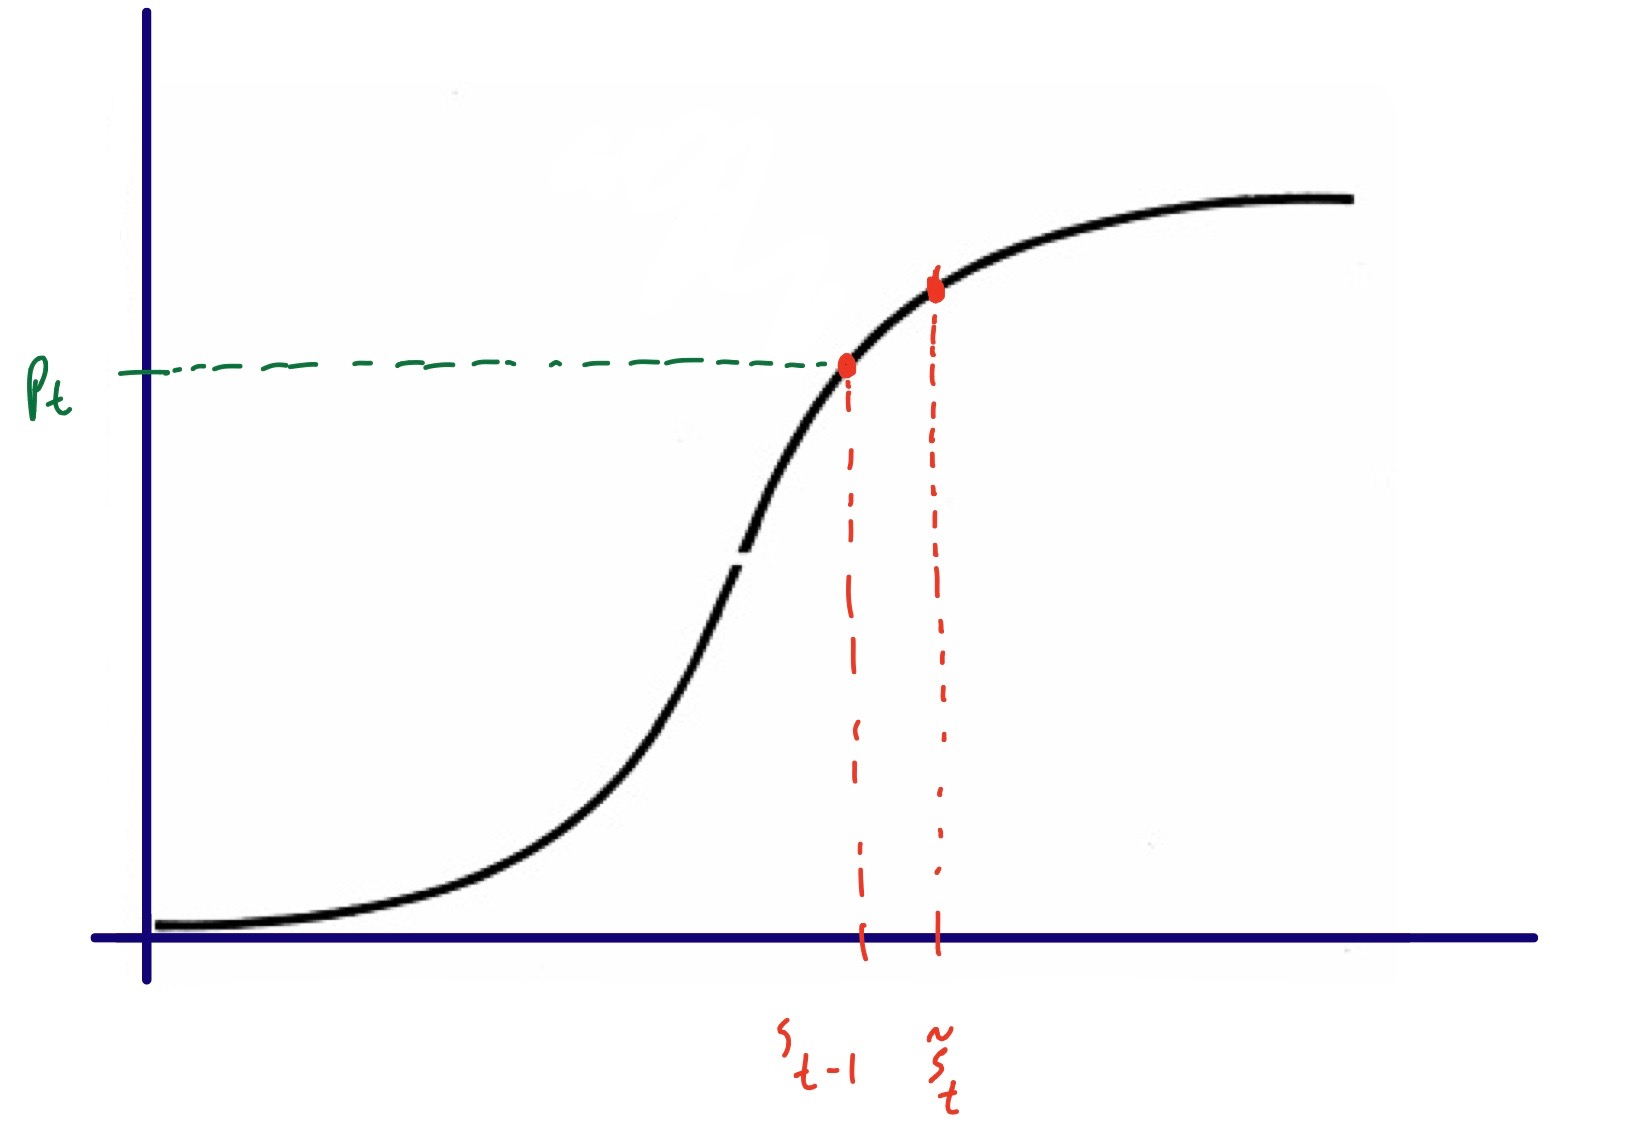

In [80]:
img_down

### Trend indeterminate

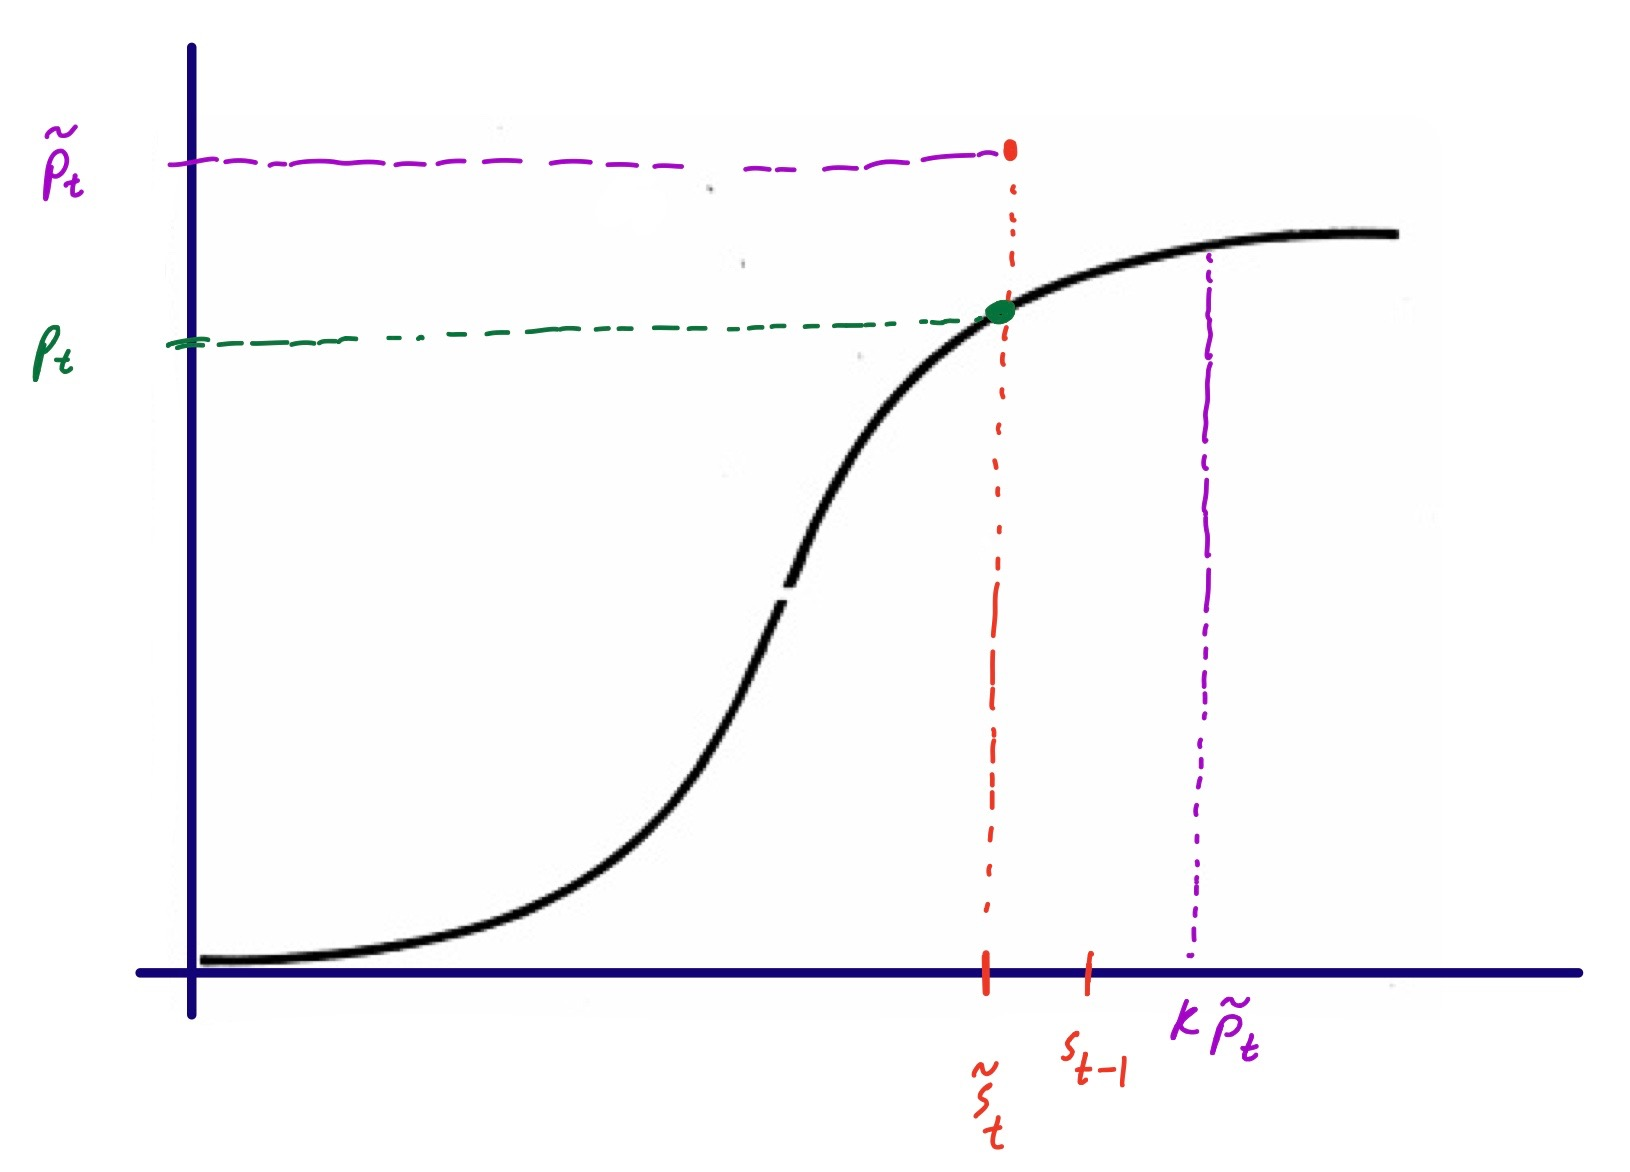

In [81]:
img_ind

### Trend up

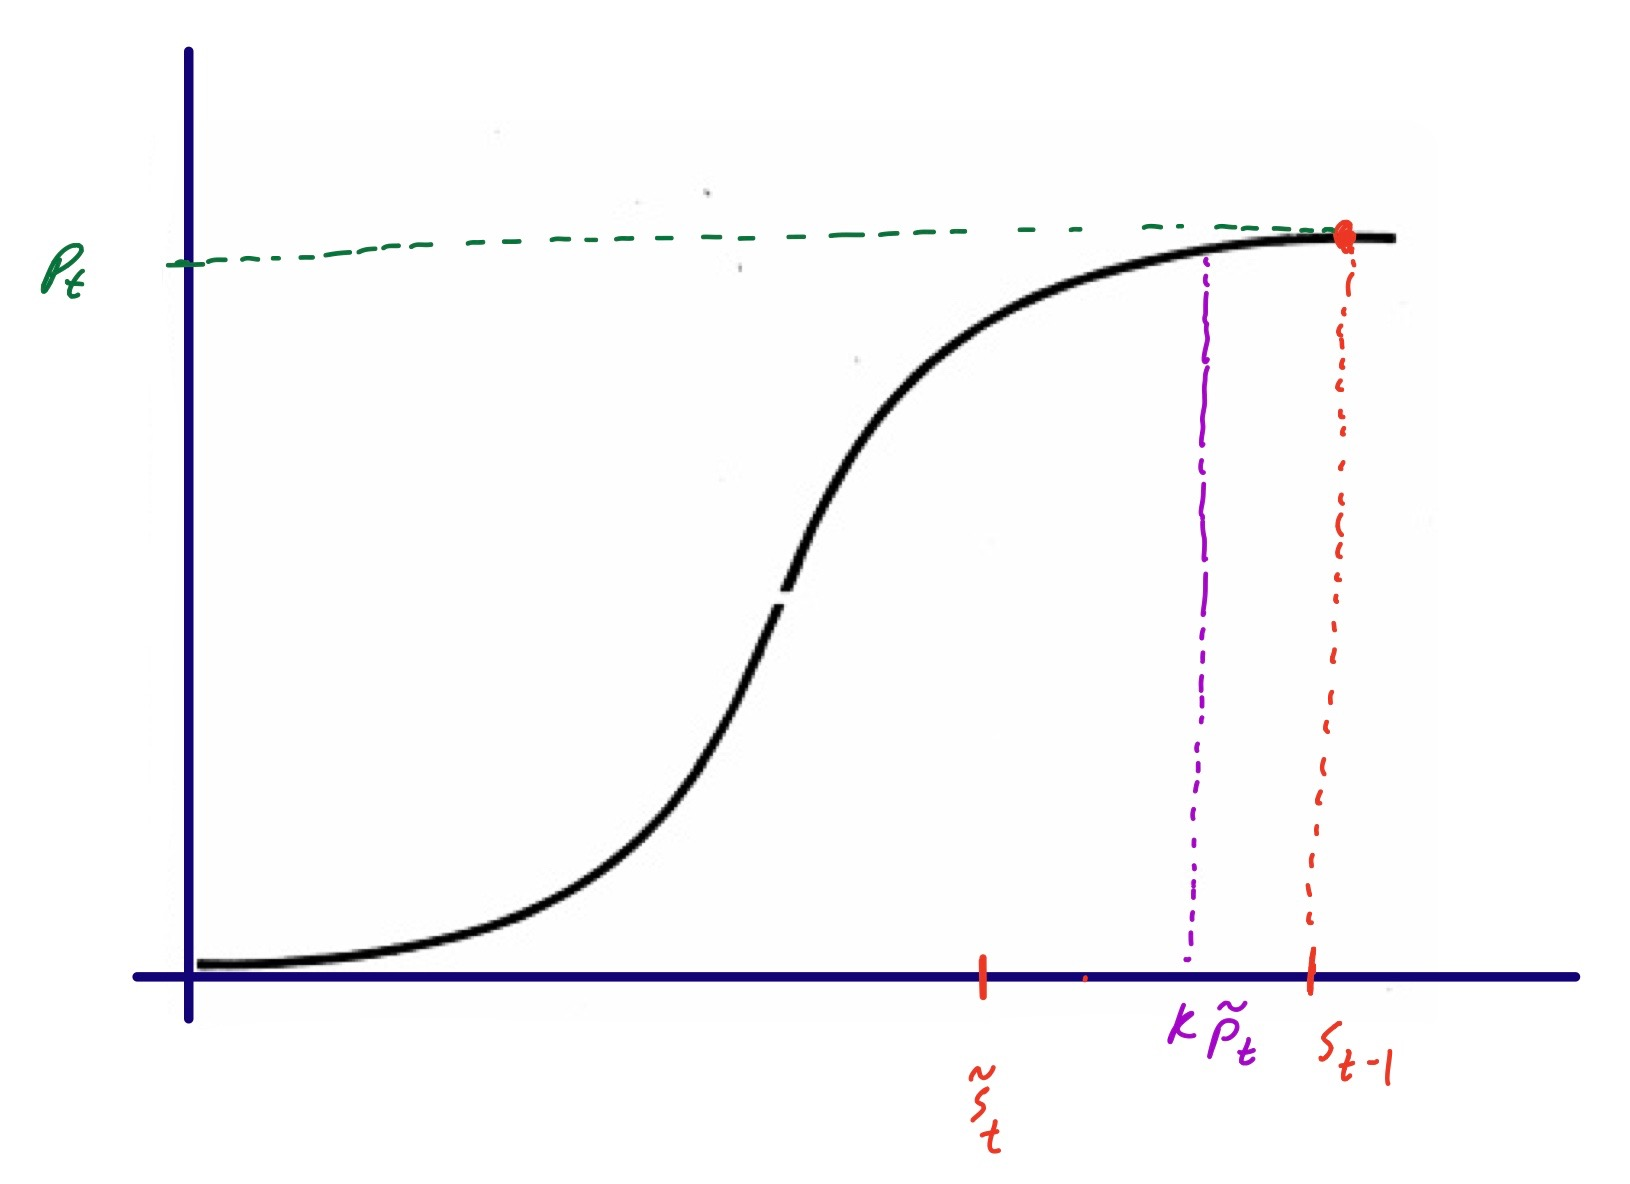

In [82]:
img_up